In [43]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

class utilities:
    @staticmethod
    def set_node_community(G, communities):
        for c, v_c in enumerate(communities):
            for v in v_c:
                G.nodes[v]['community'] = c + 1
    
    @staticmethod
    def set_edge_community(G):
        for v, w in G.edges:
            if G.nodes[v]['community'] == G.nodes[w]['community']:
                G.edges[v, w]['community'] = G.nodes[v]['community']
            else:
                G.edges[v, w]['community'] = 0
                
    @staticmethod
    def get_color(i, r_off = 1, g_off = 1, b_off = 1):
        r0, g0, b0 = 0, 0, 0
        n = 16
        low, high = 0.1, 0.9
        span = high - low
        r = low + span * (((i + r_off) * 3) % n) / (n - 1)
        g = low + span * (((i + g_off) * 5) % n) / (n - 1)
        b = low + span * (((i + b_off) * 7) % n) / (n - 1)
        return (r, g, b)
    
    @staticmethod
    def get_community_node_coloring(G):
        lst = [utilities.get_color(G.nodes[v]['community']) for v in G.nodes]
        return lst

    @staticmethod
    def get_internal_external_coloring(G):
        external = [(v, w) for v, w in G.edges 
                    if G.edges[v, w]['community'] == 0]
        internal = [(v, w) for v, w in G.edges 
                    if G.edges[v, w]['community'] > 0]
        internal_color = [get_color(G.edges[e]['community'])
                          for e in internal]
        return (external, internal, internal_color)            

def draw_community_graph(G, bridges = False):
    node_color = utilities.get_community_node_coloring(G)
    external, internal, internal_color = utilities.get_internal_external_coloring(G)
    positions = nx.spring_layout(G, seed = 42)
    plt.figure(1, figsize = (12, 12)) 
    if bridges:
        nx.draw_networkx(
            G, pos = positions,
            node_size = 0, 
            edgelist = external, 
            edge_color = "#333333")
    else:
        nx.draw_networkx(
            G, pos = positions,
            node_color = node_color,
            node_size = 0,
            edgelist = internal,
            edge_color = internal_color, alpha = 0.1, with_labels = False)

In [53]:
G_karate = nx.karate_club_graph()
communities = sorted(nx.algorithms.community.greedy_modularity_communities(G_karate), 
                     key = len,
                     reverse = True)
modularity = nx.algorithms.community.modularity(G_karate, communities)
modularity

0.3806706114398422

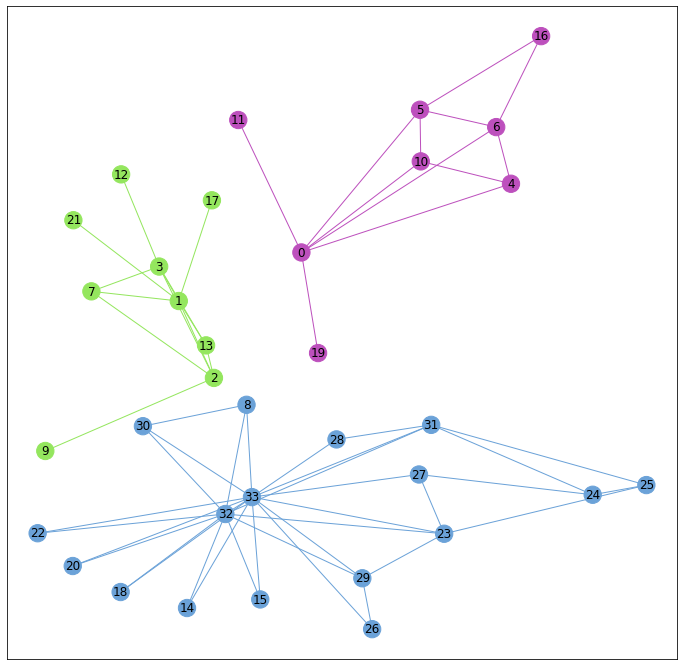

In [32]:
utilities.set_node_community(G_karate, communities)
utilities.set_edge_community(G_karate)
draw_community_graph(G_karate)

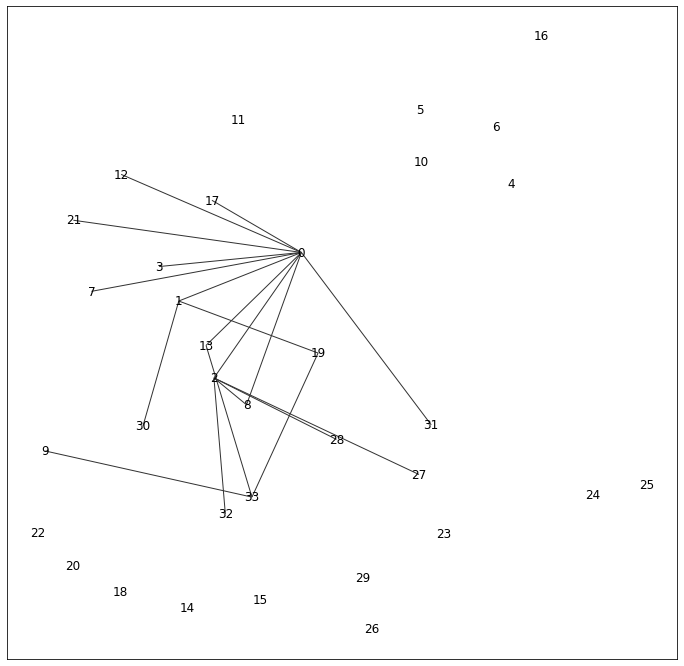

In [33]:
draw_community_graph(G_karate, bridges = True)

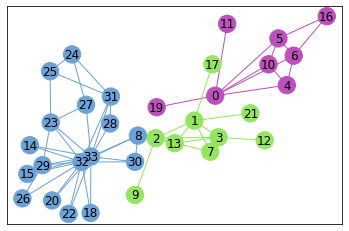

In [13]:
nx.draw_networkx(
    G_karate,
    pos = karate_pos,
    node_color = node_color,
    edgelist = internal,
    edge_color = internal_color
)

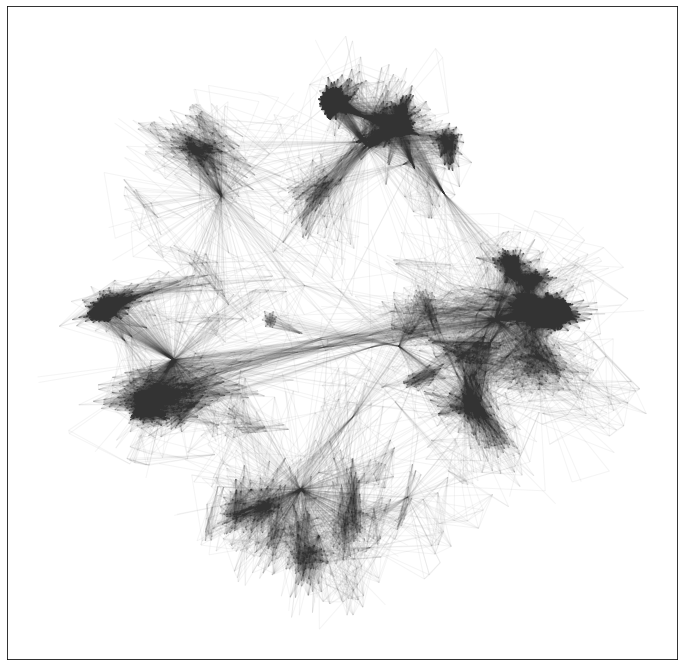

In [56]:
from pathlib import Path
G_social = nx.read_edgelist('facebook_combined.txt')
positions = nx.spring_layout(G_social, k = 0.1, seed = 42)
plt.figure(1, figsize = (12, 12))
nx.draw_networkx(G_social, pos = positions, node_size = 0, edge_color = "#333333", alpha = 0.05, with_labels = False)

In [57]:
communities = sorted(nx.algorithms.community.greedy_modularity_communities(G_social), 
                     key = len,
                     reverse = True)
modularity = nx.algorithms.community.modularity(G_social, communities)
modularity

0.7773775199040279

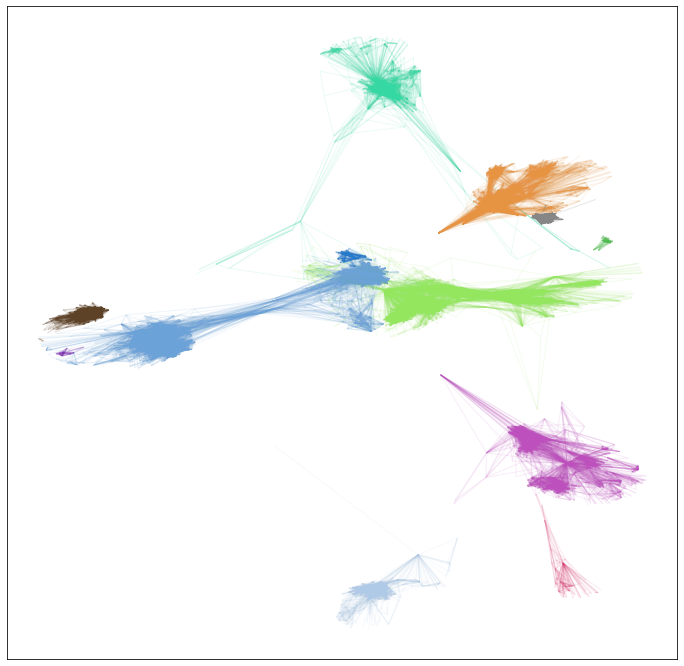

In [58]:
utilities.set_node_community(G_social, communities)
utilities.set_edge_community(G_social)
draw_community_graph(G_social)

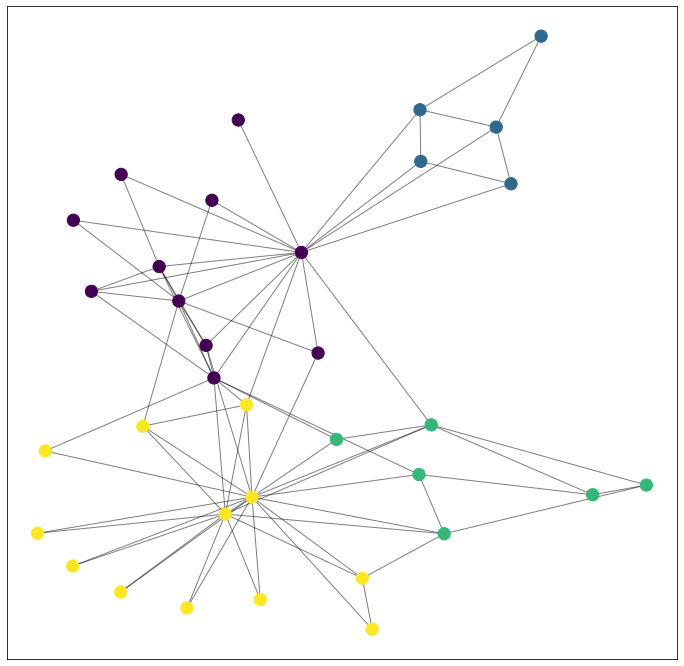

0.41978961209730437


In [100]:
import community as community_louvain
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import networkx as nx


def partition_divisor_wrapper(G, f, node_size = 150, edge_alpha = 0.5, karate_api = False):
    def forward_and_draw(G, positions, node_size, edge_alpha):
        plt.figure(1, figsize = (12, 12)) 
        nx.draw_networkx_nodes(G, positions, partition.keys(),
                               node_size = node_size, 
                               cmap = cmap,
                               node_color = list(partition.values()))
        nx.draw_networkx_edges(G, positions, alpha = edge_alpha)
        plt.show()
    if karate_api:
        model = f()
        model.fit(G)
        partition = model.get_memberships()
    else:
        partition = f(G)
    positions = nx.spring_layout(G, seed = 42)
    cmap = cm.get_cmap('viridis', max(partition.values()) + 1)
    forward_and_draw(G, positions, node_size, edge_alpha)
    print(community_louvain.modularity(partition, G))

partition_divisor_wrapper(nx.karate_club_graph(), community_louvain.best_partition)

0.8349638157840975


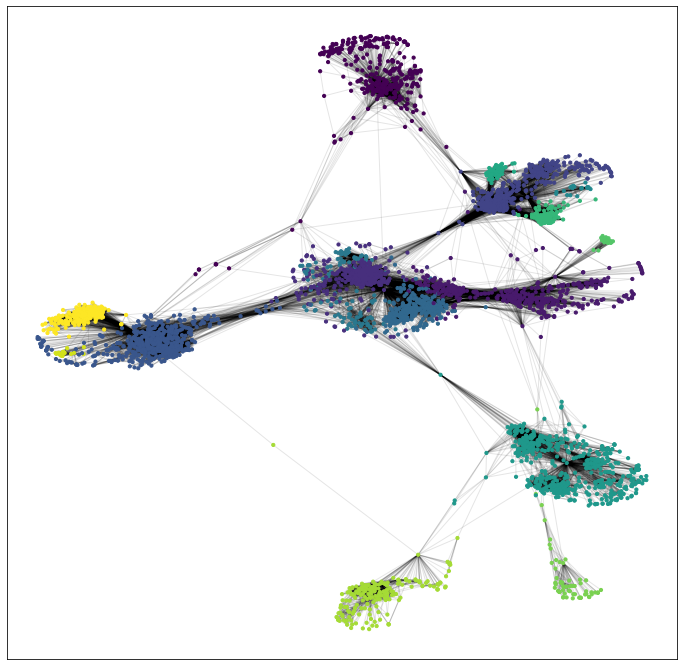

In [73]:
partition_divisor_wrapper(nx.read_edgelist('facebook_combined.txt'),
                          community_louvain.best_partition,
                          node_size = 10,
                          edge_alpha = 0.1)

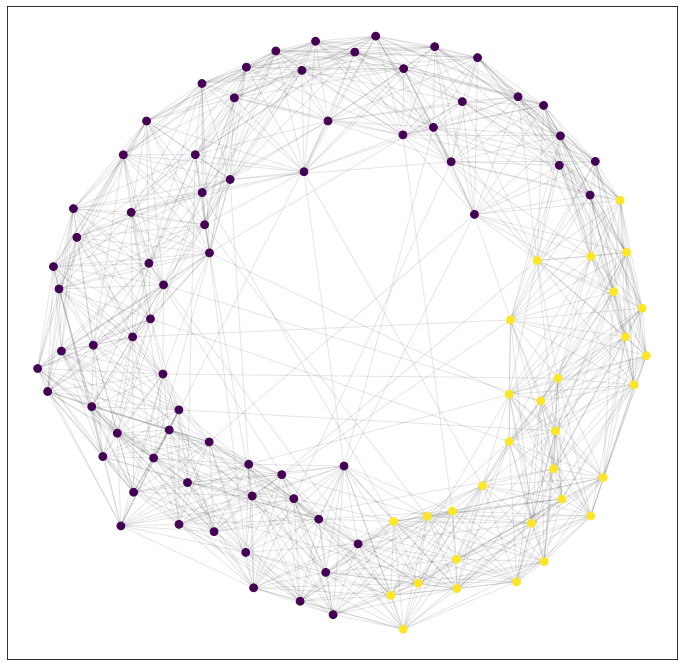

0.3043519274376417


In [104]:
import community
import networkx as nx
from karateclub import EgoNetSplitter

G = nx.newman_watts_strogatz_graph(100, 20, 0.05)
partition_divisor_wrapper(G = G,
                          f = LabelPropagation,
                          node_size = 60,
                          edge_alpha = 0.1,
                          karate_api = True)

c:\users\juggeroid\appdata\local\programs\python\python39\lib\site-packages\sklearn\decomposition\_nmf.py:1090: ConvergenceWarning: Maximum number of iterations 100 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


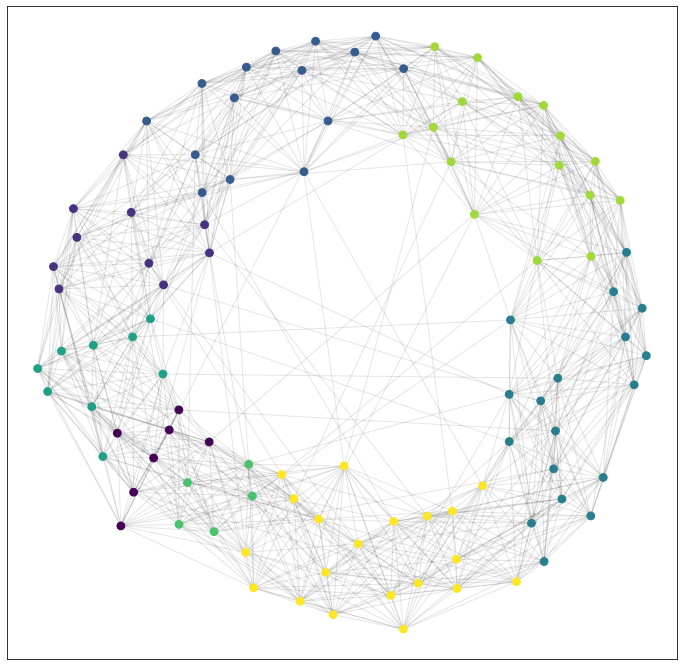

0.4114031746031746


In [110]:
from karateclub.node_embedding.neighbourhood import Walklets
from karateclub import DeepWalk
from karateclub import DANMF
partition_divisor_wrapper(G = G,
                          f = DANMF,
                          node_size = 60,
                          edge_alpha = 0.1,
                          karate_api = True)

c:\users\juggeroid\appdata\local\programs\python\python39\lib\site-packages\sklearn\decomposition\_nmf.py:1090: ConvergenceWarning: Maximum number of iterations 100 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


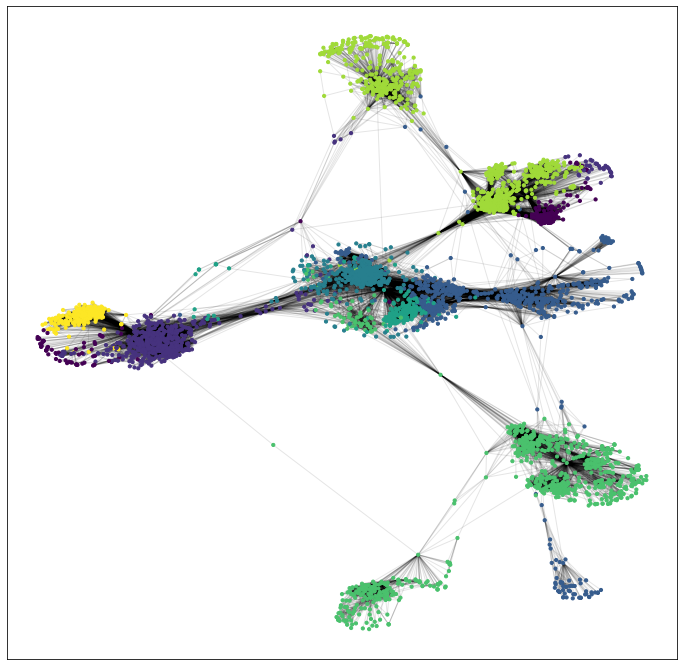

0.8033558869572067


In [117]:
G_social = nx.read_edgelist('facebook_combined.txt')
G_social = nx.convert_node_labels_to_integers(G_social)
partition_divisor_wrapper(G = G_social,
                          f = DANMF,
                          node_size = 10,
                          edge_alpha = 0.1,
                          karate_api = True)

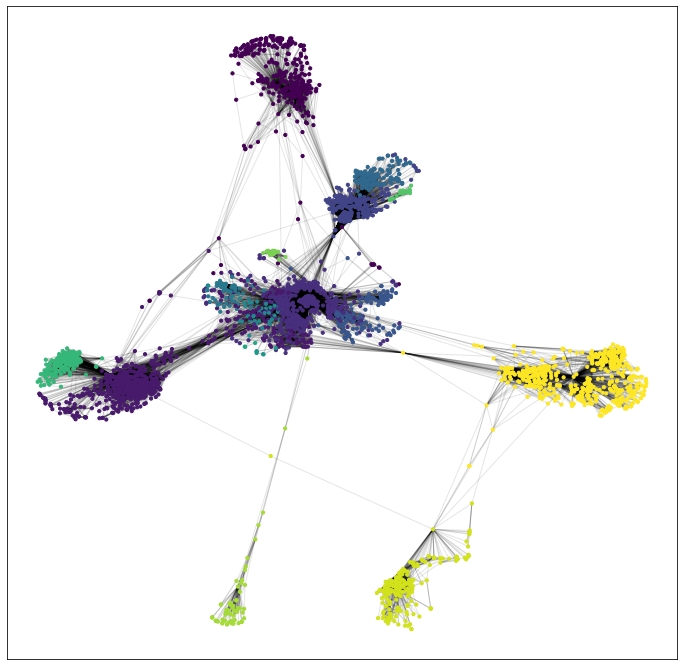

0.6052162265909903


In [120]:
from karateclub import EdMot
partition_divisor_wrapper(G = G_social,
                          f = EdMot,
                          node_size = 10,
                          edge_alpha = 0.1,
                          karate_api = True)

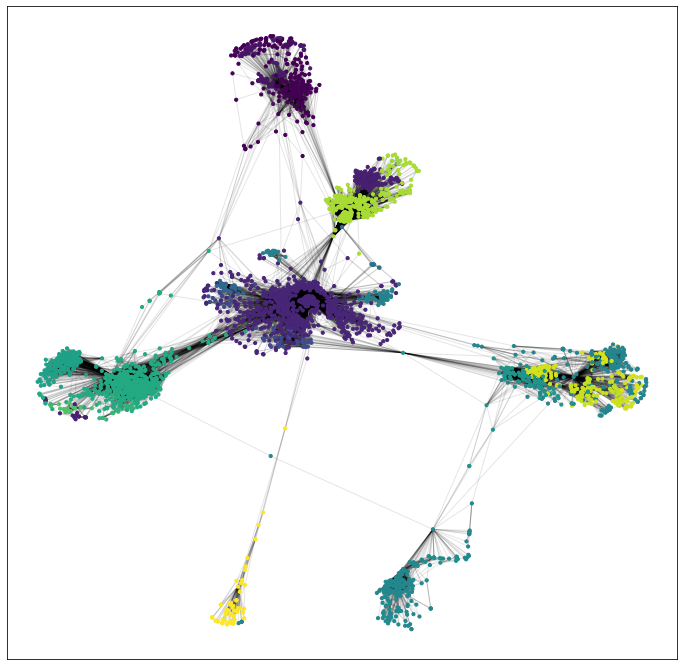

0.5959838781573176


In [121]:
from karateclub import LabelPropagation
partition_divisor_wrapper(G = G_social,
                          f = LabelPropagation,
                          node_size = 10,
                          edge_alpha = 0.1,
                          karate_api = True)